<a href="https://colab.research.google.com/github/mmsamiei/MS-Thesis-Phase3/blob/master/Models/Montazeri/Montazeri.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#In the name of God

In [1]:
import IPython
from google.colab import output

display(IPython.display.Javascript('''
  function ClickConnect(){
    console.log("Working"); 
    document.querySelector("colab-connect-button").click() 
  }
  var connect_timer = setInterval(ClickConnect,60000)
'''))

print("Done.")

<IPython.core.display.Javascript object>

Done.


In [2]:
!nvidia-smi

Fri Jun 26 19:00:26 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
!pip -q install transformers

     |████████████████████████████████| 675kB 5.7MB/s 
     |████████████████████████████████| 3.8MB 17.2MB/s 
     |████████████████████████████████| 1.1MB 55.5MB/s 
     |████████████████████████████████| 890kB 58.4MB/s 


In [5]:
from torch.utils.data import Dataset, DataLoader
import os
import torch
import json
from torch.utils.data.sampler import SubsetRandomSampler
from transformers import AutoTokenizer
import random
import pandas as pd
import logging
import os

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
from transformers import AutoModel

# Dataset

In [6]:
train_file = '/content/drive/My Drive/Thesis/phase-3/last_sentence.csv'
valid_file =  '/content/drive/My Drive/Thesis/phase-3/hkr_valid.csv'

In [7]:
enc_tokenizer = AutoTokenizer.from_pretrained('google/bert_uncased_L-2_H-128_A-2')
dec_tokenizer = AutoTokenizer.from_pretrained('google/bert_uncased_L-2_H-128_A-2')

In [8]:
class MyDataset(Dataset):
    """My dataset."""

    def __init__(self, csv_file, frac=1, split_rate=1, max_len=512, sort=True):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
        """
        self.dialogues = pd.read_csv(csv_file)
        #self.dialogues.dropna(inplace=True)
        
        self.dialogues.fillna("", inplace=True)
        self.dialogues = self.dialogues[self.dialogues.index % split_rate == 0]

        self.dialogues = self.dialogues.sample(frac=frac)
        
        s = self.dialogues['response'].apply(dec_tokenizer.encode).apply(len).sort_values().index
        self.dialogues = self.dialogues.reindex(s)

        #self.dialogues.dropna(inplace=True)

        self.max_len = max_len


    def __len__(self):
        return len(self.dialogues)

    @staticmethod
    def truncuate_join_pair_sentence(sentence1, sentence2, max_len=510):

        """
        truncuate sentence one from head and sentence two from tail
        Args:
            sentence1 (string): first sentence
            sentence2 (string): seconde sentence
        """
        temp1 = enc_tokenizer.encode(sentence1,add_special_tokens=False)
        temp2 = enc_tokenizer.encode(sentence2,add_special_tokens=False)
        ### two above line may cause warning but no problem because we've handle them below
        logging.getLogger("transformers.tokenization_utils").setLevel(logging.ERROR)
        seq_1 = temp1
        seq_2 = temp2
        num_tokens_to_remove = len(temp1) + len(temp2) + 3 - max_len
        if num_tokens_to_remove > 0 :
            seq_1, seq_2, _ = enc_tokenizer.truncate_sequences(temp1[::-1],temp2, num_tokens_to_remove=num_tokens_to_remove)
            seq_1.reverse()
        result_list = [enc_tokenizer.cls_token_id]+seq_1+[enc_tokenizer.sep_token_id]+seq_2+[enc_tokenizer.sep_token_id]
        token_type_ids = [0] * (len(seq_1) + 2) + [1] * (len(seq_2) + 1)
        return result_list, token_type_ids


    def __getitem__(self, idx):
      
        
        history = self.dialogues.iloc[idx].history
        knowledge = self.dialogues.iloc[idx].knowledge
        response = self.dialogues.iloc[idx].response


        input_pair, input_pair_segments = MyDataset.truncuate_join_pair_sentence(history, knowledge, self.max_len)
                

        input_pair = torch.LongTensor(input_pair)

        input_pair_segments = torch.LongTensor(input_pair_segments)

        response_tensor = torch.LongTensor(dec_tokenizer.encode(response))

        sample = {'input_pair': input_pair,
                  'input_pair_segments': input_pair_segments,
                  'response': response_tensor}

        return sample


In [9]:
train_dataset = MyDataset(train_file, max_len=128)
valid_dataset = MyDataset(valid_file, max_len=510)
print(len(train_dataset))
print(len(valid_dataset))

41489
4458


In [10]:
print(enc_tokenizer.decode(train_dataset[313]['input_pair']))
print(dec_tokenizer.decode(train_dataset[313]['response']))

[CLS] take - out [SEP] take - out or takeout ( in north america — u. s. [SEP]
[CLS] take out is in north america [SEP]


In [11]:
from tqdm.auto import tqdm

def my_collate_fn(batch):

  len_batch = len(batch)

  
  max_len_input_pair = max([len(data['input_pair']) for data in batch])

  max_len_response = max([len(data['response']) for data in batch])
  
  padding_ind = 0 ## for bert is 0 DON'T THINK BAD IT IS NOT REFACTORING !!!!!!
  result_input_pair = torch.zeros(len_batch, max_len_input_pair)
  result_input_pair_segments = torch.zeros(len_batch, max_len_input_pair)
  result_response = torch.zeros(len_batch, max_len_response)

  for i, data in enumerate(batch):
    p1 = len(data['input_pair'])
    result_input_pair[i, :p1] = data['input_pair']

    p3 = len(data['input_pair_segments'])
    result_input_pair_segments[i, :p3] = data['input_pair_segments']

    p4 = len(data['response'])
    result_response[i, :p4] = data['response']

  return result_input_pair.long(), result_input_pair_segments.long(), result_response.long()

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64,
                                             shuffle=True, collate_fn=my_collate_fn,
                                           num_workers=1)

#valid_sampler = torch.utils.data.SequentialSampler(valid_dataset)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=64,
                                             shuffle=False, collate_fn=my_collate_fn, num_workers=1)

i = 0 
for batch_idx, batch  in tqdm(enumerate(train_loader)):
  pair_batch, segment_batch, response_batch = batch
  print(pair_batch.shape)
  print(segment_batch.shape)
  print(response_batch.shape)
  print("****")
  i += 1 
  if(i==2):
    break

print(len(train_loader))
print(len(valid_loader))

torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 53])
****
torch.Size([64, 96])
torch.Size([64, 96])
torch.Size([64, 40])
****
649
70


In [ ]:
o = torch.rand(8,5)
o

tensor([[0.7971, 0.5570, 0.6176, 0.8620, 0.0346],
        [0.2617, 0.9808, 0.7682, 0.6243, 0.2782],
        [0.4833, 0.6336, 0.0463, 0.0938, 0.4098],
        [0.9999, 0.7067, 0.1404, 0.7106, 0.1492],
        [0.0357, 0.5070, 0.1811, 0.8164, 0.6623],
        [0.6191, 0.1194, 0.4503, 0.9537, 0.8837],
        [0.2407, 0.3513, 0.4584, 0.2995, 0.2904],
        [0.1673, 0.0891, 0.2090, 0.0751, 0.6567]])

In [ ]:
y = torch.LongTensor(8).random_(0,5)
y

tensor([2, 0, 0, 0, 4, 1, 4, 2])

In [ ]:
o[y!=2]

tensor([[0.2617, 0.9808, 0.7682, 0.6243, 0.2782],
        [0.4833, 0.6336, 0.0463, 0.0938, 0.4098],
        [0.9999, 0.7067, 0.1404, 0.7106, 0.1492],
        [0.0357, 0.5070, 0.1811, 0.8164, 0.6623],
        [0.6191, 0.1194, 0.4503, 0.9537, 0.8837],
        [0.2407, 0.3513, 0.4584, 0.2995, 0.2904]])

In [ ]:
z = torch.LongTensor(o[y!=2].shape[0]).fill_(2)
z

tensor([2, 2, 2, 2, 2, 2])

In [ ]:
torch.

In [ ]:
-1*F.nll_loss(nn.functional.log_softmax(o[y!=2]), z, reduction='mean')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  """Entry point for launching an IPython kernel.


tensor(-1.7754)

# Model

In [22]:
from transformers import EncoderDecoderModel, BertTokenizer

class Model(nn.Module):
  def __init__(self):
    super(Model, self).__init__()

    self.seq2seq = EncoderDecoderModel.from_encoder_decoder_pretrained(
        'google/bert_uncased_L-2_H-128_A-2', 'google/bert_uncased_L-2_H-128_A-2')
    
    for p in self.seq2seq.encoder.embeddings.parameters():
       p.requires_grad = False
    
    #for p in self.seq2seq.decoder.embeddings.parameters():
    #   p.requires_grad = False

  def forward(self, encoder_input, segments_tensors, decoder_input):
    '''
    encoder_input = [batch_size, enc_len]
    segments_tensors = [batch_size, enc_len]
    decoder_input = [batch_size, dec_len]
    '''
    kwargs = {'token_type_ids':segments_tensors}
    kwargs = {}
    outputs = self.seq2seq(input_ids=encoder_input, decoder_input_ids=decoder_input, **kwargs)[0]
    return outputs
  
  def generate(self, encoder_input, segments_tensors, **kwargs):
    ### encoder_input = [len] in int format
    ### segment_tensors = [len]
    encoder_input = encoder_input.unsqueeze(0)
    segments_tensors = segments_tensors.unsqueeze(0)
    
    #kwargs['token_type_ids'] = {'token_type_ids':segments_tensors}

    generated = model.seq2seq.generate(encoder_input, decoder_start_token_id=101,
                                       eos_token_id=102, ## [SEP] = 102
                                       **kwargs)

    #### generated = [1, len]
    return generated

In [23]:
dev = torch.device('cuda')
model = Model().to(dev)

# x = torch.LongTensor(200, 40).random_(1,1000).to(dev)
# print(model(x).shape)


def count_parameters(model): return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(count_parameters(model))

4978874


#Optimizer



In [24]:
class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        return 5e-5
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return self.factor * \
            (self.model_size ** (-0.5) *
            min(step ** (-0.5), step * self.warmup ** (-1.5)))
    
    def zero_grad(self):
        self.optimizer.zero_grad()

In [25]:
optimizer2 = NoamOpt(128, 1, 2000,
            torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))
optimizer = NoamOpt(128, 1, 1000,
            torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))
#optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

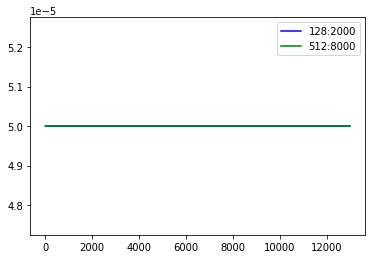

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
plt.plot(np.arange(1, 20*649), [optimizer.rate(i) for i in range(1, 20*649)], color='blue')
plt.plot(np.arange(1, 20*649), [optimizer2.rate(i) for i in range(1, 20*649)], color='green')
plt.legend(["128:2000", "512:8000", "256:4000"])

In [ ]:
print("Maximum learning rate is:",max([optimizer.rate(i) for i in range(1, 20*649)]))

Maximum learning rate is: 5e-05


In [ ]:
optimizer.rate(20000)

5e-05

In [ ]:
print("Peak step is:",max(enumerate([optimizer.rate(i) for i in range(1, 20*649)]), key=lambda x: x[1])[0])

Peak step is: 0


# Training

In [26]:
import torch.nn

def mahdi_loss(model_output, true_trg, **kwargs):
  '''
  model_output: [batch, len, hidden]
  true_trg: [batch, len]
  '''
  model_output = model_output[:,:-1,:]
  true_trg = true_trg[:,1:]

  # cold
  #T = 1
  #model_output = model_output / T

  if 'easy_training' in kwargs:
    limit_last_tokens = kwargs['easy_training']
    model_output = model_output[:,-limit_last_tokens:,:]
    true_trg = true_trg[:,-limit_last_tokens:]

  batch_len = model_output.shape[0]
  snt_len = model_output.shape[1]
  hidden_size = model_output.shape[2]

  model_output = model_output.reshape(-1, hidden_size)
  true_trg = true_trg.reshape(-1)

  loss_mod = nn.CrossEntropyLoss(ignore_index=0)## PAD = 0
  loss = loss_mod(model_output, true_trg)



  #z = torch.LongTensor(model_output[true_trg!=1045].shape[0]).fill_(1045).to(dev)
  #neg_loss = -0.5*F.nll_loss(nn.functional.log_softmax(model_output[true_trg!=1045]), z, reduction='mean')

  return loss 

In [27]:
from tqdm.auto import tqdm

def train_step(batch_idx, batch):
  pair_batch, segment_batch, response_batch = batch
  pair_batch = pair_batch.to(dev)
  segment_batch = segment_batch.to(dev)
  response_batch = response_batch.to(dev)
  model_output = model(pair_batch, segment_batch, response_batch)
  #kwargs = {'easy_training':4}
  loss = mahdi_loss(model_output, response_batch)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  del pair_batch
  del segment_batch
  del response_batch
  return loss.item()

def valid_step(batch_idx, batch):
  with torch.no_grad():
    pair_batch, segment_batch, response_batch = batch
    pair_batch = pair_batch.to(dev)
    segment_batch = segment_batch.to(dev)
    response_batch = response_batch.to(dev)
    model_output = model(pair_batch, segment_batch, response_batch)
    loss = mahdi_loss(model_output, response_batch)
    del pair_batch
    del segment_batch
    del response_batch
    return loss.item()

def valid_loop(valid_loader):
  total_loss = 0
  model.eval()
  for batch_idx, batch in tqdm(enumerate(valid_loader),  total=len(valid_loader)):
    total_loss += valid_step(batch_idx, batch)
  
  print("temperature is 1:")
  kwargs = {'num_beams':16,'num_return_sequences':16,'temperature':1}
  valid_inference(**kwargs)

  print("temperature is 0.33:")
  kwargs = {'num_beams':16,'num_return_sequences':16,'temperature':0.33}
  valid_inference(**kwargs)

  print("temperature is 2:")
  kwargs = {'num_beams':16,'num_return_sequences':16,'temperature':2}
  valid_inference(**kwargs)


  model.train()
  return total_loss / len(valid_loader)

def valid_inference(idx=313, **kwargs):
  hk_pair =  train_dataset[idx]['input_pair'].to(dev)
  hk_segment = train_dataset[idx]['input_pair_segments'].to(dev)
  response = train_dataset[idx]['response'].to(dev)
  generateds = model.generate(hk_pair, hk_segment, **kwargs)
  print("pair is: ",enc_tokenizer.decode(hk_pair))
  print("response is: ",dec_tokenizer.decode(response))
  for generated in generateds:
    print("model says: ",dec_tokenizer.decode(generated))

In [ ]:
new_learning = True
if new_learning:
  # optimizer = NoamOpt(128, 1, 2000,
  #           torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))
  model_dir = "/content/drive/My Drive/Thesis/phase-3/Models/Montazeri/"
  step = 0
  log_list = []

In [28]:
## if continue learning:
#!wget -q https://github.com/mmsamiei/MS-Thesis-Phase2/raw/master/Models/hashemi_16000steps.model
model_dir = "/content/drive/My Drive/Thesis/phase-3/Models/Montazeri"
checkpoint = torch.load(model_dir+'/montazeri_15000steps.model')
step = checkpoint['log_list'][-1]['step']
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
optimizer._step = step
log_list = checkpoint['log_list']
new_learning = False
print(step)

15000


In [ ]:
from tqdm.auto import tqdm

MAX_STEP = 20000
STEP_SAVE = 1000
STEP_CHECK = 1000
step_num = step + 1
log_list = log_list ### Check if new learning or not
print(step_num)
while step_num <= MAX_STEP:
  model.train()
  for batch_idx, batch in tqdm(enumerate(iter(train_loader)), total=len(train_loader)):
    step_loss = train_step(batch_idx, batch)
    log = {'step':step_num, 'train_loss':step_loss}

    if(step_num % STEP_CHECK == 0):
      valid_error = valid_loop(valid_loader)
      print("valid Loss rate: {} at step {}".format(valid_error, step_num))  
      log['valid_loss'] = valid_error

    log_list.append(log)

    if(step_num % STEP_SAVE == 0):
      torch.save({
            'model_state_dict': model.state_dict(),
            'log_list': log_list,
            'optimizer_state_dict': optimizer.optimizer.state_dict()
            }, model_dir+'montazeri_{}steps.model'.format(step_num))
    step_num += 1

1


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence



temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] recreational fishing [SEP] recreational fishing, also called sport fishing, is fishing for pleasure or competition. [SEP]
response is:  [CLS] do you enjoy going fishing? [SEP]
model says:  [CLS] i'm not sure, but i'm not sure, but i'm not sure
model says:  [CLS] i'm not sure, but i'm not sure. it's a lot of
model says:  [CLS] i'm not sure, but i'm not sure, but i'm sure.
model says:  [CLS] i'm not sure, but i'm not sure. i'm not sure.
model says:  [CLS] i'm not sure. i'm not sure, but i'm not sure.
model says:  [CLS] i'm not sure, but i'm sure, but i'm not sure.
model says:  [CLS] i'm not sure, but i'm not sure, but i'm sure,
model says:  [CLS] i'm not sure, but i'm not sure. i'm not sure that
model says:  [CLS] i'm not sure. i'm not sure, but i'm not sure that
model says:  [CLS] i'm not sure, but i'm not sure, but i'm sure that
model says:  [CLS] i'm not sure, but i'm sure, but i'm not sure that
model says:  [CLS] i'm not sure, but i'm not sure. i'm not sure,
model say

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] recreational fishing [SEP] recreational fishing, also called sport fishing, is fishing for pleasure or competition. [SEP]
response is:  [CLS] do you enjoy going fishing? [SEP]
model says:  [CLS] i love surfing surfing, surfing, surfing, surfing, surfing, surfing, surfing, surfing,
model says:  [CLS] i love fishing fishing, fishing, fishing, fishing, fishing, fishing, fishing, fishing,
model says:  [CLS] i love hiking hiking, hiking, hiking, hiking, hiking, hiking, hiking, hiking,
model says:  [CLS] i love surfing surfing surfing, surfing, surfing, surfing, surfing, surfing, surfing, surfing
model says:  [CLS] i love fishing fishing fishing, fishing, fishing, fishing, fishing, fishing, fishing, fishing
model says:  [CLS] i love fishing fishing is a fishing fishing fishing fishing, fishing, fishing, fishing, fishing,
model says:  [CLS] i love fishing fishing is a fishing fishing fishing fishing fishing, fishing, fishing, fishing, fishing
model says:  [CLS] i love hiking t

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence



temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] recreational fishing [SEP] recreational fishing, also called sport fishing, is fishing for pleasure or competition. [SEP]
response is:  [CLS] do you enjoy going fishing? [SEP]
model says:  [CLS] i love fishing fishing, fishing, fishing, fishing, fishing, fishing, fishing, fishing,
model says:  [CLS] i love fishing fishing fishing, fishing, fishing, fishing, fishing, fishing, fishing, fishing
model says:  [CLS] i love fishing fishing, fishing, fishing, fishing, fishing, fishing, fishing, and fishing
model says:  [CLS] i'm not sure, but i'm not sure, but i'm not sure
model says:  [CLS] i love fishing fishing, fishing, fishing, fishing, fishing, fishing, fishing, fishing and
model says:  [CLS] i love fishing fishing, fishing, fishing, fishing, fishing, fishing, and fishing, fishing
model says:  [CLS] i love fishing fishing, fishing, fishing, fishing, fishing, fishing, fishing and fishing,
model says:  [CLS] i love fishing fishing, fishing, fishing, fishing, fishing, fishin

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] recreational fishing [SEP] recreational fishing, also called sport fishing, is fishing for pleasure or competition. [SEP]
response is:  [CLS] do you enjoy going fishing? [SEP]
model says:  [CLS] i love fishing fishing, fishing, fishing, fishing, fishing, fishing, fishing, fishing,
model says:  [CLS] i love fishing fishing is a fishing fishing fishing fishing, fishing, fishing, fishing, fishing,
model says:  [CLS] i love fishing fishing fishing, fishing, fishing, fishing, fishing, fishing, fishing, fishing
model says:  [CLS] i love fishing fishing is a fishing fishing fishing, fishing, fishing, fishing, fishing, fishing
model says:  [CLS] i love fishing fishing is a fishing fishing fishing fishing fishing, fishing, fishing, fishing, fishing
model says:  [CLS] i'm not sure, but i'm not sure, but i'm not sure
model says:  [CLS] i love fishing fishing fishing is a fishing fishing fishing fishing, fishing, fishing, fishing, fishing
model says:  [CLS] i love fishing fishing i

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence



temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] recreational fishing [SEP] recreational fishing, also called sport fishing, is fishing for pleasure or competition. [SEP]
response is:  [CLS] do you enjoy going fishing? [SEP]
model says:  [CLS] i love fishing fishing, fishing, fishing, fishing, fishing, fishing, fishing, fishing,
model says:  [CLS] i love fishing fishing fishing, fishing, fishing, fishing, fishing, fishing, fishing, fishing
model says:  [CLS] i love fishing fishing, fishing, fishing, fishing, fishing, fishing, fishing, and fishing
model says:  [CLS] i love fishing fishing, fishing, fishing, fishing, fishing, fishing, and fishing, fishing
model says:  [CLS] i love fishing fishing, fishing, fishing, fishing, fishing, fishing, fishing, fishing and
model says:  [CLS] i love fishing fishing, fishing, fishing, fishing, fishing, and fishing, fishing, fishing
model says:  [CLS] i love fishing fishing, fishing, fishing, fishing, fishing, fishing, fishing, fishing is
model says:  [CLS] i love fishing fishing, fi

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] recreational fishing [SEP] recreational fishing, also called sport fishing, is fishing for pleasure or competition. [SEP]
response is:  [CLS] do you enjoy going fishing? [SEP]
model says:  [CLS] i love fishing fishing, fishing, fishing, fishing, fishing, fishing, fishing, fishing,
model says:  [CLS] i love fishing fishing fishing, fishing, fishing, fishing, fishing, fishing, fishing, fishing
model says:  [CLS] i love fishing fishing. i love fishing fishing, fishing, fishing, fishing, fishing, fishing
model says:  [CLS] i love fishing fishing is a fishing fishing fishing, fishing, fishing, fishing, fishing, fishing
model says:  [CLS] i love fishing fishing is a fishing fishing fishing fishing, fishing, fishing, fishing, fishing,
model says:  [CLS] i love fishing fishing, fishing is a fishing fishing fishing, fishing, fishing, fishing, fishing
model says:  [CLS] i love fishing fishing, fishing is a fishing fishing, fishing, fishing, fishing, fishing,
model says:  [CLS] i'

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence



temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] recreational fishing [SEP] recreational fishing, also called sport fishing, is fishing for pleasure or competition. [SEP]
response is:  [CLS] do you enjoy going fishing? [SEP]
model says:  [CLS] i'm not sure, but i'm not sure, but i'm not sure
model says:  [CLS] i'm not sure, but it's a recreational recreational activity. it's a
model says:  [CLS] i'm not sure, but i'm not sure, but it's a recreational
model says:  [CLS] i'm not sure, but it's a recreational recreational activity. [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] i'm not sure, but i'm not sure, but i'm going to
model says:  [CLS] do you like fishing? it's a recreational recreational activity. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] i'm not sure, but it's a recreational recreational recreational activity. [SEP] [SEP] [SEP]
model says:  [CLS] have you ever been fishing? it's a recreational recreational activity. [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] i'm not sure, but it's a recreational

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] recreational fishing [SEP] recreational fishing, also called sport fishing, is fishing for pleasure or competition. [SEP]
response is:  [CLS] do you enjoy going fishing? [SEP]
model says:  [CLS] i love fishing, i love fishing fishing, fishing, fishing, fishing, fishing, fishing,
model says:  [CLS] i love fishing, i love fishing, fishing, fishing, fishing, fishing, fishing, fishing
model says:  [CLS] i love fishing. i love fishing fishing, fishing, fishing, fishing, fishing, fishing,
model says:  [CLS] i love fishing fishing, fishing, fishing, fishing, fishing, fishing, fishing, fishing,
model says:  [CLS] i love fishing is a fishing fishing fishing, fishing, fishing, fishing, fishing, fishing,
model says:  [CLS] i love fishing, i love fishing and fishing, fishing, fishing, fishing, fishing, fishing
model says:  [CLS] i love fishing fishing, fishing is a fishing fishing, fishing, fishing, fishing, fishing,
model says:  [CLS] i love fishing, i love fishing. i love fishing

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence



temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] recreational fishing [SEP] recreational fishing, also called sport fishing, is fishing for pleasure or competition. [SEP]
response is:  [CLS] do you enjoy going fishing? [SEP]
model says:  [CLS] i love fishing fishing, fishing, fishing, fishing, fishing, fishing, fishing, fishing,
model says:  [CLS] i love fishing fishing, fishing, fishing, fishing, fishing, fishing, fishing, and fishing
model says:  [CLS] i love fishing fishing, fishing, fishing, fishing, fishing, fishing, fishing, fishing and
model says:  [CLS] i love fishing fishing, fishing, fishing, fishing, fishing, fishing, fishing, fishing.
model says:  [CLS] i love fishing fishing, fishing, fishing, fishing, fishing, fishing, and fishing, fishing
model says:  [CLS] i love fishing fishing, fishing, fishing, fishing, fishing, fishing, fishing, fishing is
model says:  [CLS] i love fishing fishing, fishing, fishing, fishing, fishing, fishing, fishing and fishing,
model says:  [CLS] i love fishing fishing, fishing, 

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] recreational fishing [SEP] recreational fishing, also called sport fishing, is fishing for pleasure or competition. [SEP]
response is:  [CLS] do you enjoy going fishing? [SEP]
model says:  [CLS] i love fishing fishing, fishing, fishing, fishing, fishing, fishing, fishing, fishing,
model says:  [CLS] i love fishing, i love fishing fishing, fishing, fishing, fishing, fishing, fishing,
model says:  [CLS] i love fishing fishing. i love fishing fishing, fishing, fishing, fishing, fishing, fishing
model says:  [CLS] i love fishing. i love fishing fishing, fishing, fishing, fishing, fishing, fishing,
model says:  [CLS] i love fishing fishing, fishing is a recreational activity. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] i love fishing fishing. i love fishing, fishing, fishing, fishing, fishing, fishing,
model says:  [CLS] i love fishing fishing, i love fishing, fishing, fishing, fishing, fishing, fishing,
model says:  [CLS] i love fishing, i love fishin

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence



temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] recreational fishing [SEP] recreational fishing, also called sport fishing, is fishing for pleasure or competition. [SEP]
response is:  [CLS] do you enjoy going fishing? [SEP]
model says:  [CLS] do you like fishing? it's a recreational activity. it's a recreational recreational activity
model says:  [CLS] do you like fishing? it's a recreational recreational activity. it's a recreational recreational
model says:  [CLS] do you like fishing? it's a recreational recreational activity. it's a recreational activity
model says:  [CLS] do you like fishing? it's a recreational recreational activity. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] have you ever been fishing? it's a recreational recreational activity. it's a recreational
model says:  [CLS] have you ever been fishing? it's a recreational recreational activity. [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] do you like fishing? it's a recreational recreational activity. it's a recreational sport
model says

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] recreational fishing [SEP] recreational fishing, also called sport fishing, is fishing for pleasure or competition. [SEP]
response is:  [CLS] do you enjoy going fishing? [SEP]
model says:  [CLS] i love fishing, i love fishing, fishing, fishing, fishing, fishing, fishing, fishing
model says:  [CLS] i love fishing, i love fishing fishing, fishing, fishing, fishing, fishing, fishing,
model says:  [CLS] i love fishing, i love fishing and fishing, fishing, fishing, fishing, fishing, fishing
model says:  [CLS] i love fishing, i love fishing. i love fishing fishing. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] i love fishing, i love fishing. i love fishing fishing, fishing, fishing, fishing,
model says:  [CLS] i love fishing fishing, fishing, fishing, fishing, fishing, fishing, fishing, fishing,
model says:  [CLS] i love fishing, i love fishing, i love fishing fishing, fishing, fishing, fishing,
model says:  [CLS] i love fishing. i love fishing fishing, fishing, fish

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence



temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] recreational fishing [SEP] recreational fishing, also called sport fishing, is fishing for pleasure or competition. [SEP]
response is:  [CLS] do you enjoy going fishing? [SEP]
model says:  [CLS] do you like fishing? it's a recreational activity. it's a recreational recreational activity
model says:  [CLS] do you like fishing? it's a recreational recreational activity. it's a recreational activity
model says:  [CLS] do you like fishing? it's a recreational recreational activity. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] do you like fishing? it's a recreational activity. it's a recreational activity.
model says:  [CLS] do you like fishing? it's a recreational recreational activity. it's a recreational recreational
model says:  [CLS] do you like fishing? it's a recreational activity. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] do you like fishing? it's a recreational recreational activity. it's a recreational sport
model says:  [CLS] do you li

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] recreational fishing [SEP] recreational fishing, also called sport fishing, is fishing for pleasure or competition. [SEP]
response is:  [CLS] do you enjoy going fishing? [SEP]
model says:  [CLS] i love fishing, i love fishing. i love fishing fishing. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] i love fishing, i love fishing fishing, fishing, fishing, fishing, fishing, fishing,
model says:  [CLS] i love fishing fishing. i love fishing. i love fishing fishing. [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] i love fishing. i love fishing fishing. i love fishing fishing. [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] i love fishing fishing. i love fishing fishing, fishing, fishing, fishing, fishing, fishing
model says:  [CLS] i love fishing fishing, i love fishing. i love fishing fishing. [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] i love fishing fishing. i love fishing fishing. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] i l

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence



temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] recreational fishing [SEP] recreational fishing, also called sport fishing, is fishing for pleasure or competition. [SEP]
response is:  [CLS] do you enjoy going fishing? [SEP]
model says:  [CLS] do you like fishing? it's a recreational recreational activity. [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] have you ever been fishing? it's a recreational recreational activity. [SEP] [SEP] [SEP]
model says:  [CLS] do you like fishing? it's a recreational activity. [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] have you ever been fishing? it's a recreational sport? [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] do you enjoy fishing? it's a recreational activity. [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] do you enjoy fishing? it's a recreational recreational activity. [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] have you ever been fishing? it's a recreational activity. [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] have you ever been to recreational fishing? it's a recreational re

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] recreational fishing [SEP] recreational fishing, also called sport fishing, is fishing for pleasure or competition. [SEP]
response is:  [CLS] do you enjoy going fishing? [SEP]
model says:  [CLS] i love fishing, i love fishing, i love fishing and recreational activities. [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] i love fishing, i love fishing. i love fishing fishing. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] i love fishing, i love fishing, i love fishing. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] i love fishing, i love fishing. i love fishing and recreational activities. [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] i love fishing, i love fishing, i love fishing and fishing. [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] i love fishing, i love fishing. i love fishing. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] i love fishing, i love fishing. i love fishing and fishing. [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] i lo

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence



temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] recreational fishing [SEP] recreational fishing, also called sport fishing, is fishing for pleasure or competition. [SEP]
response is:  [CLS] do you enjoy going fishing? [SEP]
model says:  [CLS] do you enjoy fishing? it's a recreational activity. it's a recreational recreational activity
model says:  [CLS] do you like fishing? it's a recreational activity. it's a recreational recreational activity
model says:  [CLS] do you enjoy fishing? it's a recreational recreational activity. it's a recreational sport
model says:  [CLS] do you enjoy fishing? it's a recreational recreational activity. it's a recreational activity
model says:  [CLS] do you like fishing? it's a recreational recreational activity. it's a recreational sport
model says:  [CLS] do you like fishing? it's a recreational recreational activity. it's a recreational activity
model says:  [CLS] do you enjoy fishing? it's a recreational recreational activity. it's a recreational recreational
model says:  [CLS] do 

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] recreational fishing [SEP] recreational fishing, also called sport fishing, is fishing for pleasure or competition. [SEP]
response is:  [CLS] do you enjoy going fishing? [SEP]
model says:  [CLS] i love fishing, i love fishing, i love fishing. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] i love fishing, i love fishing, i love fishing, i love fishing. [SEP] [SEP] [SEP]
model says:  [CLS] i love fishing, i love fishing, i love fishing, but i love fishing. [SEP] [SEP]
model says:  [CLS] i love fishing, i love fishing, i love fishing and recreational activities. [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] i love fishing, i love fishing, i love fishing. i love fishing. [SEP] [SEP] [SEP]
model says:  [CLS] i love fishing, i love fishing. i love fishing, i love fishing. [SEP] [SEP] [SEP]
model says:  [CLS] i love fishing, i love fishing. i love fishing and recreational activities. [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] i love fishing, i love fishing. i love f

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence



temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] recreational fishing [SEP] recreational fishing, also called sport fishing, is fishing for pleasure or competition. [SEP]
response is:  [CLS] do you enjoy going fishing? [SEP]
model says:  [CLS] do you enjoy fishing? it's a recreational recreational activity. it's a recreational sport
model says:  [CLS] do you enjoy fishing? it's a recreational activity. it's a recreational recreational activity
model says:  [CLS] do you like fishing? it's a recreational recreational activity. it's a recreational sport
model says:  [CLS] do you enjoy fishing? it's a recreational recreational activity. it's a recreational activity
model says:  [CLS] do you enjoy fishing? it's a recreational recreational activity. it's a recreational recreational
model says:  [CLS] do you enjoy fishing? it's a recreational activity. it's a recreational recreational sport
model says:  [CLS] do you like fishing? it's a recreational recreational activity. it's a recreational recreational
model says:  [CLS] d

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] recreational fishing [SEP] recreational fishing, also called sport fishing, is fishing for pleasure or competition. [SEP]
response is:  [CLS] do you enjoy going fishing? [SEP]
model says:  [CLS] i love fishing, i love fishing, i love fishing and fishing. [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] i love fishing, i love fishing. i love fishing and fishing. [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] i love fishing, i love fishing. i've been fishing for recreational fishing. [SEP] [SEP]
model says:  [CLS] i love fishing, i love fishing, i've been fishing for recreational fishing. [SEP] [SEP]
model says:  [CLS] i love fishing, i love fishing. it's a recreational activity. [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] i love fishing, i love fishing. it's a recreational sport [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] i love fishing, i love fishing, i love fishing and recreational fishing. [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] i love fishing, i love fishin

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence



temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] recreational fishing [SEP] recreational fishing, also called sport fishing, is fishing for pleasure or competition. [SEP]
response is:  [CLS] do you enjoy going fishing? [SEP]
model says:  [CLS] do you like fishing? it's a recreational recreational activity. it's a recreational sport
model says:  [CLS] do you enjoy fishing? it's a recreational recreational activity. it's a recreational sport
model says:  [CLS] do you like fishing? it's a recreational recreational activity. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] do you like fishing? it's a recreational recreational activity. it's a recreational recreational
model says:  [CLS] have you ever been fishing? it's a recreational recreational activity. it's a recreational
model says:  [CLS] do you like fishing? it's a recreational sport [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] do you enjoy fishing? it's a recreational recreational activity. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] recreational fishing [SEP] recreational fishing, also called sport fishing, is fishing for pleasure or competition. [SEP]
response is:  [CLS] do you enjoy going fishing? [SEP]
model says:  [CLS] i love fishing, i love fishing, i love fishing. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] i love fishing, i love fishing. it's a recreational sport [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] i love fishing, i love fishing, i love fishing and recreational fishing. [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] i love fishing, i love fishing, i love fishing, i love fishing. [SEP] [SEP] [SEP]
model says:  [CLS] i love fishing, i love fishing, it's a recreational sport [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] i love fishing, i love fishing, i love fishing, but i'm a recreational sport
model says:  [CLS] i love fishing, i love fishing. i love fishing fishing. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] i love fishing, i love fishing, i love fis

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence



temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] recreational fishing [SEP] recreational fishing, also called sport fishing, is fishing for pleasure or competition. [SEP]
response is:  [CLS] do you enjoy going fishing? [SEP]
model says:  [CLS] have you ever been fishing? it's a recreational sport. it's a recreational sport
model says:  [CLS] have you ever been fishing? it's a recreational sport? [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] do you like fishing? it's a recreational sport? [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] do you like fishing? it's a recreational sport. it's also a recreational sport
model says:  [CLS] do you like fishing? it's a recreational sport [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] do you like fishing? it's a recreational sport. it's a recreational sport.
model says:  [CLS] do you enjoy fishing? it's a recreational sport? [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] do you enjoy fishing? it's a recreational sport [SEP] 

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] recreational fishing [SEP] recreational fishing, also called sport fishing, is fishing for pleasure or competition. [SEP]
response is:  [CLS] do you enjoy going fishing? [SEP]
model says:  [CLS] i love fishing, i love fishing. it's a recreational sport [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] i love fishing, i love fishing, i love fishing and recreational fishing. [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] i love fishing, i love fishing. it is a recreational sport [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] i love fishing, i love fishing, i love fishing. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] i love fishing, i love fishing and recreational fishing. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] i love fishing, i love fishing, i love fishing and recreational activities. [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] i love fishing, i love fishing, it's a recreational sport [SEP] [SEP] [SEP] [SEP] [SEP]
model says: 

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence



temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] recreational fishing [SEP] recreational fishing, also called sport fishing, is fishing for pleasure or competition. [SEP]
response is:  [CLS] do you enjoy going fishing? [SEP]
model says:  [CLS] do you like fishing? it's a recreational sport? [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] do you like fishing? it's a recreational sport. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] do you like fishing? it's a recreational sport. it's a recreational sport.
model says:  [CLS] do you enjoy fishing? it's a recreational sport. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] do you enjoy fishing? it's a recreational sport? [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] do you enjoy fishing? it's a recreational activity. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] do you like fishing? it's a recreational activity. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] do you like fishing? it's a recr

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] recreational fishing [SEP] recreational fishing, also called sport fishing, is fishing for pleasure or competition. [SEP]
response is:  [CLS] do you enjoy going fishing? [SEP]
model says:  [CLS] i love fishing, i love fishing, i love fishing. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] i love fishing, i love fishing, i love fishing, but i love fishing. [SEP] [SEP]
model says:  [CLS] i love fishing, i love fishing, i love fishing and recreational fishing. [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] i love fishing, i love fishing, i love fishing, but i'm a recreational sport
model says:  [CLS] i love fishing, i love fishing. i love fishing and recreational fishing. [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] i love fishing, i love fishing and recreational fishing. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] i love fishing, i love fishing, i love fishing, but i'm a fishing sport
model says:  [CLS] i love fishing, i love fishing. it is 

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence



temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] recreational fishing [SEP] recreational fishing, also called sport fishing, is fishing for pleasure or competition. [SEP]
response is:  [CLS] do you enjoy going fishing? [SEP]
model says:  [CLS] do you like fishing? it's a recreational sport. it's also a recreational sport
model says:  [CLS] do you like fishing? it's a recreational sport? [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] do you like fishing? it's a recreational sport. it's a recreational sport.
model says:  [CLS] i love fishing. i love fishing. it's a recreational sport. it's a
model says:  [CLS] do you like fishing? it's a recreational sport [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] do you like fishing? it's a recreational sport. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] do you like fishing? it's a recreational sport or recreational fishing? [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] do you like fishing? it's a recreational sport. it's a recreation

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] recreational fishing [SEP] recreational fishing, also called sport fishing, is fishing for pleasure or competition. [SEP]
response is:  [CLS] do you enjoy going fishing? [SEP]
model says:  [CLS] i love fishing, i love fishing. it's a recreational sport [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] i love fishing, i love fishing. it is a recreational sport [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] i love fishing, i love fishing, i love fishing and recreational fishing. [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] i love fishing, i love fishing, i love fishing. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] i love fishing, i love fishing. i love fishing and recreational fishing. [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] i love fishing, i love fishing, it's a recreational sport [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] i love fishing, i love fishing and recreational fishing. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [C

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence



temperature is 1:


Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] recreational fishing [SEP] recreational fishing, also called sport fishing, is fishing for pleasure or competition. [SEP]
response is:  [CLS] do you enjoy going fishing? [SEP]
model says:  [CLS] do you like fishing? it's a recreational sport? [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] do you like fishing? it's a recreational sport [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] have you ever been fishing? it's a recreational sport, it's a recreational sport
model says:  [CLS] have you ever been fishing? it's a recreational sport? [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] do you enjoy fishing? it's a recreational sport? [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] have you ever been to recreational fishing? it's a recreational sport? [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] have you ever been fishing? it's a recreational sport [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] do you enjoy fish

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] recreational fishing [SEP] recreational fishing, also called sport fishing, is fishing for pleasure or competition. [SEP]
response is:  [CLS] do you enjoy going fishing? [SEP]
model says:  [CLS] i love fishing, i love fishing, it's a recreational sport [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] i love fishing, i love fishing. it's a recreational sport [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] i love fishing, i love fishing. it is a recreational sport [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] i love fishing, i love fishing, i love fishing. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] i love fishing, i love fishing, i've been fishing for pleasure. [SEP] [SEP] [SEP]
model says:  [CLS] i love fishing, it's a recreational sport [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] i love fishing, i love fishing, i love to swim. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] i love fishing. i love fishing, i

In [35]:
kwargs = {'num_beams':8,
          'num_return_sequences':8,'temperature':1, 'max_length':50, 'early_stopping':True,
          'no_repeat_ngram_size':3
          }
valid_inference(idx=1000, **kwargs)

Setting `pad_token_id` to 102 (first `eos_token_id`) to generate sequence


pair is:  [CLS] yeah, but none of them use android they have their own custom os mostly. [SEP] initially developed by android inc., which google bought in 2005, android was unveiled in 2007, with the first commercial android device launched in september 2008. [SEP]
response is:  [CLS] android was bought by google in 2005. [SEP]
model says:  [CLS] i'm not sure, but i don't know that they've been around since 2007. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] i'm not sure, but i don't know that they've been around since 2007, it was released in 2007. [SEP]
model says:  [CLS] i'm not sure, but i don't know that they've been around since 2007, it was released in 2006. [SEP]
model says:  [CLS] i'm not sure, but i don't know that they've been around since 2005. [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] i'm not sure, but i don't know that, but they've been around since 2007. [SEP] [SEP] [SEP] [SEP] [SEP]
model says:  [CLS] i'm not sure, but i don't know that

In [ ]:
log_list

[{'step': 1, 'train_loss': 10.614270210266113},
 {'step': 2, 'train_loss': 10.733108520507812},
 {'step': 3, 'train_loss': 10.35904312133789},
 {'step': 4, 'train_loss': 10.361538887023926},
 {'step': 5, 'train_loss': 9.957269668579102},
 {'step': 6, 'train_loss': 9.948104858398438},
 {'step': 7, 'train_loss': 9.55443286895752},
 {'step': 8, 'train_loss': 9.504170417785645},
 {'step': 9, 'train_loss': 9.426634788513184},
 {'step': 10, 'train_loss': 9.070025444030762},
 {'step': 11, 'train_loss': 8.891423225402832},
 {'step': 12, 'train_loss': 8.783164024353027},
 {'step': 13, 'train_loss': 8.70628547668457},
 {'step': 14, 'train_loss': 8.569317817687988},
 {'step': 15, 'train_loss': 8.292956352233887},
 {'step': 16, 'train_loss': 8.274083137512207},
 {'step': 17, 'train_loss': 7.799631595611572},
 {'step': 18, 'train_loss': 8.041912078857422},
 {'step': 19, 'train_loss': 7.653815269470215},
 {'step': 20, 'train_loss': 7.699405670166016},
 {'step': 21, 'train_loss': 7.541056156158447},


In [ ]:
loss = nn.CrossEntropyLoss()
input = torch.randn(3, 5, requires_grad=True)
target = torch.empty(3, dtype=torch.long).random_(5)
output = loss(input, target)
print(output)
output.backward()

tensor(1.5508, grad_fn=<NllLossBackward>)
